In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

device = torch.device('cuda')  # To run on GPU

# Steps to Train and Test a CNN

#### **(1) In a Network Class, define the following:**
1. A network 
  (note: we will define only a forward pass, because the backward pass is automatic)
2. An optimizer
3. A loss function 


#### **(2) Train the model**
1. Get a training dataset and put into DataLoader()
2. Repeat the following for N epochs:

  a. Iterate through the training dataset and do the following for each *batch* of data:

         i. Output = Net(input)

         ii. Compute loss and perform back propagation 

          iii. Run optimizer

  b. Bookkeeping 


#### **(3) Test the model**
1. Get a test dataset
2. Iterate through the test dataset and do the following for each *batch* of data:

    a. Output = Net(input)

    b. Bookkeeping

# **Task 1 - Classification with CIFAR10**

**Load and examine data**

"[The dataloader provides a Python iterator returning tuples and the enumerate will add the step](https://discuss.pytorch.org/t/iterating-through-a-dataloader-object/25437). \[...\] The `step, (x, y)` works due to “tuple unpacking”, again a general Python thing."

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device==torch.device('cuda') else {}
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../data', train=True, download=True,
                                                                    transform=transforms.Compose([transforms.ToTensor(),
                                                                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))       # Calculate mean and standard deviation of dataset
                                                                                      ])), batch_size=512, shuffle=True, **kwargs)


Extracting ../data/cifar-10-python.tar.gz to ../data


In [ ]:
len(train_loader)

98

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"batch_idx: {batch_idx}")
    print(f"data shape: {data.shape}")
    print(f"target shape: {target.shape}")

batch_idx: 0
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 1
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 2
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 3
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 4
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 5
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 6
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 7
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 8
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 9
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 10
data shape: torch.Size([512, 3, 32, 32])
target shape: torch.Size([512])
batch_idx: 11
data shape: torch.Size([512, 3, 32, 32]

In [ ]:
it = iter(train_loader)
first = next(it)
second = next(it)
print(f"Length of it: {len(it)}")
print(f"Length of first: {len(first)}")
print(f"Length of second: {len(second)}")

Length of it: 98
Length of first: 2
Length of second: 2


In [ ]:
print(f"Shape of first[0]: {first[0].shape}")
print(f"Shape of first[1]: {first[1].shape}")
print(f"Shape of first[0] min value: {first[0].min()}")
print(f"Shape of first[0] max value: {first[0].max()}")
print(f"List of unique numerical labels: {first[1].unique()}")

Shape of first[0]: torch.Size([512, 3, 32, 32])
Shape of first[1]: torch.Size([512])
Shape of first[0] min value: -2.429065704345703
Shape of first[0] max value: 2.7537312507629395
List of unique numerical labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
print(f"Shape of second[0]: {second[0].shape}")
print(f"Shape of second[1]: {second[1].shape}")
print(f"Shape of second[0] min value: {second[0].min()}")
print(f"Shape of second[0] max value: {second[0].max()}")
print(f"List of unique numerical labels: {second[1].unique()}")

Shape of second[0]: torch.Size([512, 3, 32, 32])
Shape of second[1]: torch.Size([512])
Shape of second[0] min value: -2.429065704345703
Shape of second[0] max value: 2.7537312507629395
List of unique numerical labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Thus, we have 98 batches of 512 images of dimensions 32 x 32 and 3 channels. Each image has a numerical integer label from 0 to 9. Let's take a look at a couple of these images with their respective numerical labels:

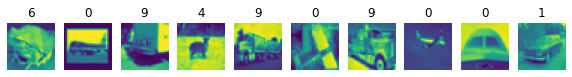

In [ ]:
data,target=first
plt.figure(figsize=(10, 100))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.imshow(data[i, 0].cpu())
  plt.axis('off')
  plt.title(target[i].item())

plt.show()

## **(A) Without Residual Connection**

**Defining NN without Residual Connection**

In [ ]:
class Net(nn.Module): 

  def __init__(self): 
    super(Net, self).__init__()
    
    # x: 32 x 32 x 3 channels
    self.cv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1) # 32 filters: 3 x 3 x 3 channels
    # (input size + (2 x padding) - dilation x (filterize -1) - 1)/stride + 1
    # 30 x 30 x 32 channels  # (32 + (2 x 0) - 1 x (3 -1) - 1)/1 + 1 # (32 - 2 - 1)/1 + 1
    self.cv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=1) # 64 filters: 3 x 3 x 32 channels
    # 28 x 28 x 64 channels (output_dim=30-3+1)
    self.fc1 = nn.Linear(in_features=50176, out_features=128) # 50176 = 28 x 28 x 64
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.sm1 = nn.LogSoftmax(dim=1) # gives you a probability between 0 and 1

  def forward(self, x): 
    out = F.relu(self.cv1(x))   # Conv Layer 1 + ReLU  # 30 x 30 x 32 channels
    out = F.relu(self.cv2(out)) # Conv Layer 2 + ReLU # 28 x 28 x 64 channels 
 
    out = out.view(out.size(0), -1) # Reshape from 28 x 28 x 64 to  50176 x 1

    out = F.relu(self.fc1(out)) # Fully Connected Layer 1 + ReLu # 128 x 1
    out = self.fc2(out) # Fully Connected Layer 2 # 128 x 1
    out = self.sm1(out) # Log Softmax Activation Function
    
    return out
    
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) 
lossfun = nn.NLLLoss() # maximum likelihood estimation; other options: MSE(), CE()

**Train your model**

In [ ]:
def train(model, train_loader, epochs): 
  model.train() 

  epoch_loss = []
  epoch_accu = []

  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):

      data, target = data.to(device), target.to(device)

      output = model(data)

      loss = lossfun(output, target)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      ##### Bookkeeping

      accuracy = (output.argmax(-1)==target).float().mean() # 512 x 1 vector where each entry is whether or not the highest 
        # probability label output by the model corresponds to the actual target label
      epoch_loss.append(loss.item())
      epoch_accu.append(accuracy.item())
        # accuracy: 1%
        # accuracy: 7%
        # accuracy: 10%
        # accuracy: 15%
    # accuracy.item([1,7,10,15])

      if batch_idx % 50 == 0: 
        print('Train Epoch: {}[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}'.format(
            epoch+1, batch_idx*len(data), len(train_loader.dataset), 
            100. * batch_idx / len(train_loader), loss.item(), accuracy.item()))
      
      print('Train Epoch: {}\tAverage Loss: {:.6f}\tAverage Accuracy: {:.2f}'.format(
            epoch+1, sum(epoch_loss)/len(epoch_loss), sum(epoch_accu)/len(epoch_accu)))

  torch.save(model.state_dict(), 'cifar10_cnn.pt')

  return epoch_loss, epoch_accu

In [ ]:
epoch_loss, epoch_accu = train(model, train_loader, epochs=1)

Train Epoch: 1[0/50000 (0%)]	Loss: 2.307506	Accuracy: 0.11
Train Epoch: 1	Average Loss: 2.307506	Average Accuracy: 0.11
Train Epoch: 1	Average Loss: 2.891344	Average Accuracy: 0.12
Train Epoch: 1	Average Loss: 2.814567	Average Accuracy: 0.13
Train Epoch: 1	Average Loss: 2.748353	Average Accuracy: 0.15
Train Epoch: 1	Average Loss: 2.667573	Average Accuracy: 0.16
Train Epoch: 1	Average Loss: 2.599395	Average Accuracy: 0.17
Train Epoch: 1	Average Loss: 2.545678	Average Accuracy: 0.18
Train Epoch: 1	Average Loss: 2.500762	Average Accuracy: 0.18
Train Epoch: 1	Average Loss: 2.464129	Average Accuracy: 0.19
Train Epoch: 1	Average Loss: 2.435101	Average Accuracy: 0.19
Train Epoch: 1	Average Loss: 2.411422	Average Accuracy: 0.19
Train Epoch: 1	Average Loss: 2.391129	Average Accuracy: 0.19
Train Epoch: 1	Average Loss: 2.370171	Average Accuracy: 0.19
Train Epoch: 1	Average Loss: 2.350026	Average Accuracy: 0.20
Train Epoch: 1	Average Loss: 2.333545	Average Accuracy: 0.20
Train Epoch: 1	Average Los

Plot the loss

Text(0, 0.5, 'accuracy')

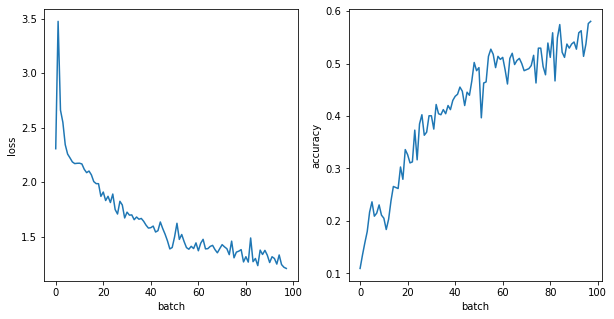

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)

plt.plot(epoch_loss)
plt.xlabel('batch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(epoch_accu)
plt.xlabel('batch')
plt.ylabel('accuracy')

**Testing**

In [ ]:
#kwargs = {'num_workers': 1, 'pin_memory': True} if device==torch.device('cuda') else {}
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])),
    batch_size=512, shuffle=True, **kwargs)

In [ ]:
def test(model, test_loader):
  model.eval()    # Put model in evaluation mode
  test_loss = 0
  test_accu = 0

  with torch.no_grad(): 

    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      ## Bookkeeping
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      test_accu += (output.argmax(dim=-1)==target).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_accu /= len(test_loader.dataset)



    print('\nTest set: Average Loss: {:.4f}, Accuracy: {:.2f}\n'.format(test_loss, test_accu))
    
    return test_loss, test_accu

In [ ]:
test_loss, test_accu = test(model, test_loader)


Test set: Average Loss: 1.2575, Accuracy: 0.56



## **(B) With Residual Connection**

**Defining NN without Residual Connection**

In [ ]:
class Net(nn.Module): 

  def __init__(self): 
    super(Net, self).__init__()
    
    # x: 32 x 32 x 3 channels
    self.cv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1) # 32 filters: 3 x 3 x 3 channels
    # 30 x 30 x 32 channels (output_dim=32-3+1)
    self.cv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=1) # 64 filters: 3 x 3 x 32 channels
    # 28 x 28 x 64 channels (output_dim=30-3+1)

    # residual connection
        # input x: 32 x 32 x 3 channels
        # output resized to fit previous output: 28 x 28 x 64 
    self.shortcut = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)

    self.fc1 = nn.Linear(in_features=50176, out_features=128) # 50176 = 28 x 28 x 64
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    self.sm1 = nn.LogSoftmax(dim=1)


  def forward(self, x): 
    residual = x
    out = F.relu(self.cv1(x))   # Conv Layer 1 + ReLU
    out = F.relu(self.cv2(out)) # Conv Layer 2 + ReLU

    out += self.shortcut(residual)   

    out = out.view(out.size(0), -1) # Reshape from 28 x 28 x 64 to  50176 x 1

    out = F.relu(self.fc1(out)) # Fully Connected Layer 1
    out = self.fc2(out) # Fully Connected Layer 2
    out = self.sm1(out) # Log Softmax Activation Function
    
    return out
    
model_with_rc = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) 
lossfun = nn.NLLLoss()

** train your model (we do not need to rewrite a "train" function!)

In [ ]:
epoch_loss2, epoch_accu2 = train(model_with_rc, train_loader, epochs=1)

Train Epoch: 1[0/50000 (0%)]	Loss: 2.298979	Accuracy: 0.11
Train Epoch: 1	Average Loss: 2.298979	Average Accuracy: 0.11
Train Epoch: 1	Average Loss: 2.304161	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.315882	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.317947	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.316508	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.314060	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.313795	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.314978	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.315452	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.315281	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.315052	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.315334	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.314641	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.313857	Average Accuracy: 0.10
Train Epoch: 1	Average Loss: 2.312804	Average Accuracy: 0.10
Train Epoch: 1	Average Los

**Testing**

In [ ]:
test_loss, test_accu = test(model_with_rc, test_loader)


Test set: Average Loss: 2.3140, Accuracy: 0.11



# Task 2: Autoencoding with CIFAR10

**Defining a autoencoder NN**

In [ ]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()

         # x: 32 x 32 x 3 channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1) # 32 filters: 3 x 3 x 3 channels
        # 30 x 30 x 32 channels (output_dim=32-3+1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, dilation=1)
        # 14 x 14 x 64 channels (output_dim=(30-4)/2+1) = 12544
        self.fc1 = nn.Linear(in_features=12544, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=12544)
        self.convT1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0)
        self.convT2 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=0)

    def encoder(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1) # reshape from 14 x 14 x 64  to 12544 x 1
        x = self.fc1(x)
        return x
    
    def decoder(self, x):
        x = self.fc2(x)
        x = x.view(x.size(0), 64, 14, 14)
        x = F.relu(x)
        x = self.convT1(x)
        x = F.relu(x)
        x = self.convT2(x)
        return torch.sigmoid(x)
    
    def forward(self, x):
        l = self.encoder(x)
        output = self.decoder(l)
        return output
    

model_ae1 = Net3().to(device)
optimizer_ae1 = optim.Adam(model_ae1.parameters(), lr=0.0001) # optimizer
lossfun_ae1 = nn.MSELoss() # loss function

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device==torch.device('cuda') else {}
ae_train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../data', train=True, download=True,
                                                                    transform=transforms.Compose([transforms.ToTensor()      # Calculate mean and standard deviation of dataset
                                                                                      ])), batch_size=512, shuffle=True, **kwargs)

Files already downloaded and verified


In [ ]:
epochs = 5
epoch_loss_ae1 = 0

for epoch in range(epochs):
    
    # iterate through train dataset
    
    for batch_idx, (data, _) in enumerate(ae_train_loader):
        
        data = data.to(device)
        
        # get output
        output = model_ae1(data)
        
        # compute loss function
        loss = lossfun_ae1(output, data)
        
        # backward pass
        optimizer_ae1.zero_grad()
        loss.backward()
        
        # run optimizer 
        optimizer_ae1.step()
        
        # bookkeeping
        epoch_loss_ae1 += loss.item() * data.size(0)
        
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(ae_train_loader.dataset),
                100. * batch_idx / len(ae_train_loader), loss.item()))
            
    print('Train Epoch: {}\tAverage Loss: {:.6f}'.format(
        epoch+1, epoch_loss_ae1/len(ae_train_loader.dataset)))
            
# save network
torch.save(model_ae1.state_dict(), "mnist_ae.pt")

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.064801
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.046767
Train Epoch: 1	Average Loss: 0.048132
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.028321
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.022024
Train Epoch: 2	Average Loss: 0.070567
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.018447
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.016224
Train Epoch: 3	Average Loss: 0.087776
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.016381
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.014741
Train Epoch: 4	Average Loss: 0.102904
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.014349
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.013846
Train Epoch: 5	Average Loss: 0.116755


**Testing**

In [ ]:
ae_test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()])),
    batch_size=512, shuffle=True, **kwargs)

In [ ]:
model_ae1.eval() 
test_loss_ae1 = 0

with torch.no_grad(): # no need to compute gradients; also saves time and memory
    
    # iterate through test set
    for data, _ in ae_test_loader:
        data = data.to(device)
        
        # forward pass
        output_ae1 = model_ae1(data)
        
        # bookkeeping
        #test_loss_ae1 += nn.MSELoss(output_ae1, data, reduction='mean').item()*data.size(0)
        test_loss_ae1 += F.binary_cross_entropy(output_ae1, data, reduction='mean').item()*data.size(0)  # loss


test_loss_ae1 /= len(test_loader.dataset)

print('\nTest set: Average Loss: {:.4f}\n'.format(
    test_loss_ae1))


Test set: Average Loss: 0.5820



Take a look at some of your input images (first row) and some of the images generated by your autoencoder (second row)

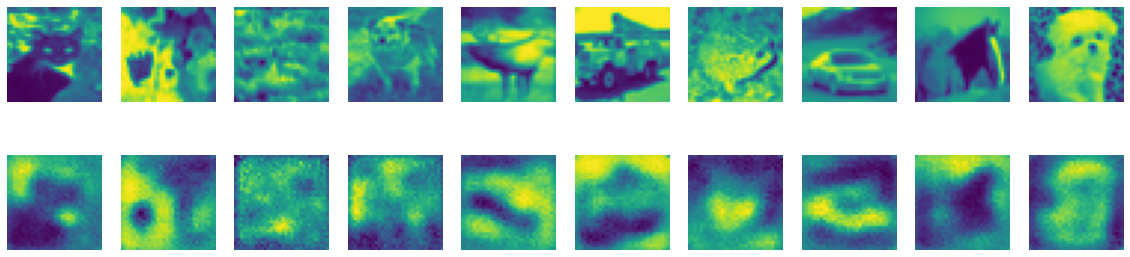

In [ ]:
plt.close('All')
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(data[i,0].cpu())
    plt.axis('off')
    plt.subplot(2,10,10+i+1)
    plt.imshow(output_ae1[i,0].detach().cpu())
    plt.axis('off')
    
plt.show()

**Same model with additional Dropout Layer**

On dropout layers: randomly set input units to 0 at a predetermined frequency (here, it is 25% of the time) to avoid overfitting! Will this improve the model?

In [ ]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, dilation=1)
        self.fc1 = nn.Linear(in_features=12544, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=12544)
        self.convT1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0)
        self.convT2 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=0)
        self.dp1 = nn.Dropout2d(p=0.25)

    def encoder(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dp1(x)          # Add dropout layer
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
    def decoder(self, x):
        x = self.fc2(x)
        x = x.view(x.size(0), 64, 14, 14)
        x = F.relu(x)
        x = self.convT1(x)
        x = F.relu(x)
        x = self.convT2(x)
        return torch.sigmoid(x)
    
    def forward(self, x):
        l = self.encoder(x)

        # Add dropout layer
        #l = self.dp1(l)

        output = self.decoder(l)
        return output
    


model_ae2 = Net4().to(device)

# Let's define an optimizer

optimizer_ae2 = optim.Adam(model_ae2.parameters(), lr=0.001)

# Let's define a Loss function

lossfun_ae2 = nn.MSELoss()

In [ ]:
epochs = 5
epoch_loss_ae2 = 0

for epoch in range(epochs):
    
    # iterate through train dataset
    
    for batch_idx, (data, _) in enumerate(ae_train_loader):
        
        data = data.to(device)
        
        # get output
        output = model_ae2(data)
        
        # compute loss function
        loss = lossfun_ae2(output, data)
        
        # backward pass
        optimizer_ae2.zero_grad()
        loss.backward()
        
        # run optimizer 
        optimizer_ae2.step()
        
        # bookkeeping
        epoch_loss_ae2 += loss.item() * data.size(0)
        
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(ae_train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    print('Train Epoch: {}\tAverage Loss: {:.6f}'.format(
        epoch+1, epoch_loss_ae2/len(ae_train_loader.dataset)))
            
# save network
torch.save(model_ae2.state_dict(), "mnist_ae2.pt")

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.067569
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.024548
Train Epoch: 1	Average Loss: 0.030848
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.016676
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.013077
Train Epoch: 2	Average Loss: 0.044318
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.012785
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.009510
Train Epoch: 3	Average Loss: 0.054021
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.008679
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.008054
Train Epoch: 4	Average Loss: 0.061850
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.007380
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.006590
Train Epoch: 5	Average Loss: 0.068592


**Testing**

In [ ]:
test_loss_ae2 = 0

with torch.no_grad(): # no need to compute gradients; also saves time and memory
    
    # iterate through test set
    for data, _ in ae_test_loader:
        data = data.to(device)
        
        # forward pass
        output_ae2 = model_ae2(data)
        
        # bookkeeping
        test_loss_ae2 += F.binary_cross_entropy(output_ae2, data, reduction='mean').item()*data.size(0)  # loss

test_loss_ae2 /= len(ae_test_loader.dataset)

print('\nTest set: Average Loss: {:.4f}\n'.format(
    test_loss_ae2))


Test set: Average Loss: 0.5645



Let's (once again) take a look at some of your input images (first row) and some of the images generated by your autoencoder (second row)

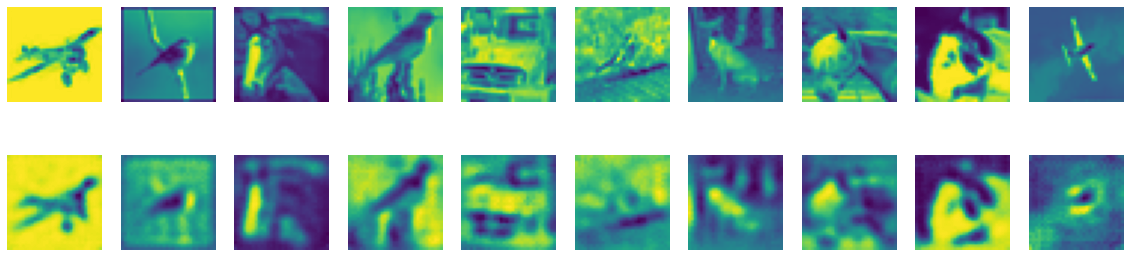

In [ ]:
plt.close('All')
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(data[i,0].cpu())
    plt.axis('off')
    plt.subplot(2,10,10+i+1)
    plt.imshow(output_ae2[i,0].detach().cpu())
    plt.axis('off')
    
plt.show()